<a href="https://colab.research.google.com/github/yashdosi/airflow/blob/master/yash_tft_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is built and tested in Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-forecasting ta optuna statsmodels optuna-integration[pytorch_lightning]

  Using cached pytorch_forecasting-1.3.0-py3-none-any.whl.metadata (13 kB)
  Preparing metadata (setup.py) ... done
  Using cached lightning-2.5.1.post0-py3-none-any.whl.metadata (39 kB)
  Using cached lightning_utilities-0.14.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached torchmetrics-1.7.1-py3-none-any.whl.metadata (21 kB)
  Using cached pytorch_lightning-2.5.1.post0-py3-none-any.whl.metadata (20 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using

In [ ]:
import os
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import torch
import pytorch_lightning as pl

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, TorchNormalizer
from pytorch_forecasting.metrics import SMAPE
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'capstone_project'
user = 'ydosi3'
if user == 'ydosi3':
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive',
                                   'MyDrive/Colab Notebooks', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
else:
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive',
                                   GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

os.environ['GOOGLE_DRIVE_PATH'] = GOOGLE_DRIVE_PATH

os.environ['GOOGLE_DRIVE_PATH']

['data', 'utils', 'src', 'models_results', 'notebooks', 'data_processing.ipynb']


'/content/drive/MyDrive/Colab Notebooks/capstone_project'

In [ ]:
# hyperparams
TRAINING_DATA_RATIO = 0.85
VALIDATION_DATA_RATIO = 0.15
# TESTING_DATA_RATIO = 0.1

data_base = f"{os.environ['GOOGLE_DRIVE_PATH']}/data"
data = pd.read_csv(f"{data_base}/NIFTY 50_minute_data.csv", parse_dates=['date'])
data['cal_date'] = pd.to_datetime(data['date'].dt.date)

daily_data = pd.read_csv(f"{data_base}/NIFTY 50_daily_data.csv", parse_dates=['date'])
daily_data['date'] = pd.to_datetime(daily_data['date'])
# Calculate the percentage gap between the current day's open and the previous day's close
daily_data['previous_close'] = daily_data['close'].shift(1)
daily_data['gap_percentage'] = ((daily_data['open'] - daily_data['previous_close']) / daily_data['previous_close']) * 100

gap_threshold = 0.7
# Categorize the gap as 'gap_up', 'gap_down', or 'no_gap'
daily_data['gap_type'] = np.where(daily_data['gap_percentage'] > gap_threshold, 'gap_up',
                                 np.where(daily_data['gap_percentage'] < -gap_threshold, 'gap_down', 'no_gap'))

vix_min = pd.read_csv(f"{data_base}/INDIA VIX_minute.csv", parse_dates=['date'])
# Rename columns in the 'data' DataFrame
vix_min = vix_min.rename(columns={
    'date': 'vix_date',
    'open': 'vix_open',
    'high': 'vix_high',
    'low': 'vix_low',
    'close': 'vix_close',
    'volume': 'vix_volume'
})
vix_min.drop(columns=['vix_volume'], inplace=True)

In [ ]:
# Rename columns in the 'data' DataFrame
data = data.rename(columns={
    'date': 'min_date',
    'open': 'min_open',
    'high': 'min_high',
    'low': 'min_low',
    'close': 'min_close',
    'volume': 'min_volume'
})
data['hour'] = data['min_date'].dt.hour
data['hour'] = data['hour'].astype(str)

data["hour_start"] = data["min_date"].dt.floor("h")
# Calculate the return from the start of the hour
data = data.merge(data.groupby("hour_start")["min_close"].first(), on="hour_start", suffixes=("", "_start"))
data["hourly_return"] = (data["min_close"] - data["min_close_start"]) / data["min_close_start"]

In [ ]:
merged_data = pd.merge(data, daily_data, left_on='cal_date', right_on='date', how='left')
merged_data = pd.merge(merged_data, vix_min, left_on='min_date', right_on='vix_date', how='left')
merged_data = merged_data.drop(['volume', 'min_volume', 'previous_close', 'open', 'high', 'low',
                                'close', 'date', 'cal_date', 'vix_date', 'hour_start'], axis=1)
merged_data = merged_data.rename(columns={
    'min_open': 'open',
    'min_high': 'high',
    'min_low': 'low',
    'min_close': 'close',
})

In [ ]:
merged_data.head()

,min_date,open,high,low,close,hour,min_close_start,hourly_return,gap_percentage,gap_type,vix_open,vix_high,vix_low,vix_close
0,2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,9,8292.1,0.000000,0.617516,no_gap,16.47,16.47,14.46,15.39
1,2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,9,8292.1,-0.000476,0.617516,no_gap,15.39,15.47,15.33,15.45
2,2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,9,8292.1,0.000217,0.617516,no_gap,15.45,15.51,15.41,15.46
3,2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,9,8292.1,0.001031,0.617516,no_gap,15.46,15.50,15.33,15.40
4,2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,9,8292.1,0.001097,0.617516,no_gap,15.39,15.40,15.29,15.35


In [ ]:
RSI_WINDOW = 30
EMA_1 = 60
EMA_2 = 120
MACD_SLOW_WINDOW = 120
MACD_FAST_WINDOW = 45
MACD_SIGNAL_WINDOW = 9
STOCH_WINDOW = 45

merged_data["stock"] = "NIFTY_IDX"

# Calculate RSI
merged_data['RSI'] = ta.momentum.RSIIndicator(merged_data['close'], window=RSI_WINDOW).rsi()

# Calculate MACD
macd = ta.trend.MACD(merged_data['close'], window_slow=MACD_SLOW_WINDOW,
                     window_fast=MACD_FAST_WINDOW, window_sign=MACD_SIGNAL_WINDOW)
merged_data['MACD'] = macd.macd()
merged_data['MACD_signal'] = macd.macd_signal()
merged_data['MACD_diff'] = macd.macd_diff()

# Calculate Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(merged_data['high'], merged_data['low'], merged_data['close'], window=STOCH_WINDOW)
merged_data['stoch'] = stoch.stoch()
merged_data['stoch_signal'] = stoch.stoch_signal()

# Add ema slow and fast
merged_data['ema_slow'] = ta.trend.EMAIndicator(merged_data['close'], window=EMA_2).ema_indicator()
merged_data['ema_fast'] = ta.trend.EMAIndicator(merged_data['close'], window=EMA_1).ema_indicator()

merged_data.dropna(axis=0, how='any', inplace=True)

# add index column
merged_data["time_idx"] = merged_data.index


In [ ]:
import math

def calculate_batch_size(total_samples, target_batch_count=100):
    """Calculates the batch size as the nearest power of 2 for 100 batches.

    Args:
        total_samples: The total number of samples.

    Returns:
        The calculated batch size.
    """

    ideal_batch_size = total_samples // target_batch_count
    power_of_two = round(math.log2(ideal_batch_size))
    batch_size = 2**power_of_two
    return batch_size


In [ ]:
column_list = [
    'open', 'high', 'low', 'close', 'gap_percentage', 'gap_type',
    'vix_open', 'vix_high', 'vix_low', 'vix_close', 'hour',
    'min_close_start', 'hourly_return', 'RSI', 'MACD', 'MACD_signal',
    'MACD_diff', 'stoch', 'stoch_signal', 'ema_slow', 'ema_fast', 'stock'
]

# column_list = [
#     'open', 'close', 'stock',  'high', 'low'
# ]
forecast_window = 10 # days
lookback_factor = 5
forecast_start_date = pd.to_datetime('2022-04-01')

lookback_window = max(90, forecast_window * lookback_factor)
forecast_end_date = forecast_start_date + pd.DateOffset(days=forecast_window)

training_start_date = forecast_start_date - pd.DateOffset(days=lookback_window)
# training_end_date = forecast_end_date - pd.DateOffset(days=lookback_window)

print(f"training start date: {training_start_date}")
print(f"training end date: {forecast_start_date}")
print(f"forecast start date: {forecast_start_date}")
print(f"forecast end date: {forecast_end_date}")
df1 = merged_data[merged_data['min_date'] < forecast_start_date]
df1 = df1[df1['min_date'] >= training_start_date]
df2 = merged_data[merged_data['min_date'] >= forecast_start_date]
df2 = df2[df2['min_date'] < forecast_end_date]
data1 = df1[column_list]
test_df = df2[column_list]

TOTAL_DATA_LEN = data1.shape[0]

# # add index column
# data1["time_idx"] = data1.index
# test_df["time_idx"] = test_df.index

df = data1[:TOTAL_DATA_LEN]

train_df = df[:int(TOTAL_DATA_LEN*TRAINING_DATA_RATIO)]
val_df = df[int(TOTAL_DATA_LEN*TRAINING_DATA_RATIO):
            int(TOTAL_DATA_LEN*(TRAINING_DATA_RATIO+VALIDATION_DATA_RATIO))]

train_df.reset_index()
train_df["time_idx"] = train_df.index

val_df.reset_index()
val_df["time_idx"] = val_df.index

test_df.reset_index()
test_df["time_idx"] = test_df.index
# test_df = df[int(TOTAL_DATA_LEN*(TRAINING_DATA_RATIO+VALIDATION_DATA_RATIO)):]

training start date: 2022-01-01 00:00:00
training end date: 2022-04-01 00:00:00
forecast start date: 2022-04-01 00:00:00
forecast end date: 2022-04-11 00:00:00


<ipython-input-11-54f0160ee346>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["time_idx"] = train_df.index
<ipython-input-11-54f0160ee346>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["time_idx"] = val_df.index
<ipython-input-11-54f0160ee346>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [ ]:
print("Close Column Statistics:")
print(f"Minimum: {train_df['close'].min()}")
print(f"Maximum: {train_df['close'].max()}")
print(f"Mean: {train_df['close'].mean()}")
print(f"Median: {train_df['close'].median()}")
# Calculate mode - it might have multiple modes
from scipy import stats
mode_result = stats.mode(train_df['close'])
# print(mode_result)
print(f"Mode: {mode_result.mode} (count: {mode_result.count})")


Close Column Statistics:
Minimum: 15674.25
Maximum: 18347.95
Mean: 17272.40018517566
Median: 17326.75
Mode: 15785.4 (count: 26)


In [ ]:
print("Close Column Statistics:")
print(f"Minimum: {val_df['close'].min()}")
print(f"Maximum: {val_df['close'].max()}")
print(f"Mean: {val_df['close'].mean()}")
print(f"Median: {val_df['close'].median()}")
# Calculate mode - it might have multiple modes
from scipy import stats
mode_result = stats.mode(val_df['close'])
# print(mode_result)
print(f"Mode: {mode_result.mode} (count: {mode_result.count})")

Close Column Statistics:
Minimum: 17006.9
Maximum: 17556.8
Mean: 17266.38870591664
Median: 17252.45
Mode: 17226.45 (count: 5)


In [ ]:
# TODO:
# These two will be known during the forecasting.
#   Add hourly metrics - they serve has more recent market sentiment (evoling during the day)
# Can we get all features and do a PCA over that?
# How can we use grouping? Does hourly grouping make sense? How is grouping useful in TFT?
# Will return till hour from open be a useful feature?
# Scaling

# Findings:
# min_close_start & hourly_return did not help - maybe it helps with the return_on_day column?

In [ ]:
train_df.shape[0]

19441

In [ ]:
train_df.columns

Index(['open', 'high', 'low', 'close', 'gap_percentage', 'gap_type',
       'vix_open', 'vix_high', 'vix_low', 'vix_close', 'hour',
       'min_close_start', 'hourly_return', 'RSI', 'MACD', 'MACD_signal',
       'MACD_diff', 'stoch', 'stoch_signal', 'ema_slow', 'ema_fast', 'stock',
       'time_idx'],
      dtype='object')

In [ ]:
from torchmetrics.regression import MeanSquaredError
from pytorch_forecasting.data import TimeSeriesDataSet
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scalers = {
    'open': MinMaxScaler(),
    'high': MinMaxScaler(),
    'low': MinMaxScaler(),
    # 'close': MinMaxScaler(),
    'vix_open': MinMaxScaler(),
    'vix_high': MinMaxScaler(),
    'vix_low': MinMaxScaler(),
    'vix_close': MinMaxScaler(),
    'RSI': MinMaxScaler(),
    'MACD': MinMaxScaler(),
    'MACD_signal': MinMaxScaler(),
    'MACD_diff': MinMaxScaler(),
    'stoch': MinMaxScaler(),
    'stoch_signal': MinMaxScaler(),
    'ema_slow': MinMaxScaler(),
    'ema_fast': MinMaxScaler(),
}

In [ ]:
max_encoder_length =    60 # experiment with higher input windows
max_prediction_length = 10 # forecast horizon (10 minutes)

training_data = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="close",
    group_ids=["stock"],
    # Fixed history and forecast lengths:
    min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["gap_percentage"],
    time_varying_unknown_reals=['open', 'close', 'vix_close', 'ema_fast', 'hourly_return',
                                'MACD_signal', 'MACD_diff', 'stoch', 'stoch_signal', 'ema_slow'],
    target_normalizer=GroupNormalizer(
        groups=["stock"], transformation="softplus"
    ),
    allow_missing_timesteps=True,
    scalers=scalers,
    # add_relative_time_idx=True,
    # add_target_scales=True,
    # add_encoder_length=True,
)

# Create dataloaders for training and validation:
batch_size = calculate_batch_size(train_df.shape[0], 200)
print(f"Batch size: {batch_size}")
train_dataloader = training_data.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

# Build the validation dataset from the same dataset (ensuring consistent preprocessing)
validation_data = TimeSeriesDataSet.from_dataset(
    training_data, val_df, stop_randomization=True, predict=True,
    min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length
)

valid_dataloader = validation_data.to_dataloader(batch_size=batch_size, num_workers=0, train=False)
l = "smape"
# ---------------------------
# 4. Build and train the TFT model
# ---------------------------
# We use TemporalFusionTransformer.from_dataset to auto-configure many model parameters.
tft = TemporalFusionTransformer.from_dataset(
    training_data,
    learning_rate=0.007,
    hidden_size=9,             # size of internal layers (tune based on your data)
    attention_head_size=7,      # number of attention heads
    dropout=0.05,
    hidden_continuous_size=9,   # dimensionality for continuous variable processing
    output_size=1,              # default output size (used for quantile forecasts)
    loss=MeanSquaredError() if l == "mse" else SMAPE(),               # Symmetric Mean Absolute Percentage Error
    log_interval=10,
    reduce_on_plateau_patience=4,
    causal_attention=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")

# Configure a PyTorch Lightning Trainer:
trainer = pl.Trainer(
    max_epochs=10,
    gradient_clip_val=0.75,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Wrap the TFT model with the PyTorch Lightning module
class TFTLightningModule(pl.LightningModule):
    def __init__(self, tft):
        super().__init__()
        # self.tft = tft
        self.model = tft
        self.train_losses_per_epoch = []
        self.validation_losses_per_epoch = []
        # self.save_hyperparameters(ignore=["model", "loss", "logging_metrics"])

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.model.loss(y_hat["prediction"][:, :, 0], y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True,
                 batch_size=x['encoder_target'].shape[0])
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        # print(y_hat["prediction"][:, :, 0])
        # print(y)
        # loss = MeanSquaredError().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))(y_hat["prediction"][:, :, 0], y[0])
        loss = self.model.loss(y_hat["prediction"][:, :, 0], y)
        self.log("val_loss", loss, prog_bar=True, batch_size=x['encoder_target'].shape[0])
        return loss

    def test_step(self, batch, batch_idx):
        # Perform a single test step
        x, y = batch
        out = self.model(x)
        y_pred = out[0]  # The model output is a tuple, 'y_pred' is the first element
        # loss = MeanSquaredError().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))(y_pred, y)
        loss = self.model.loss(y_pred["prediction"][:, :, 0], y)
        self.log("test_loss", loss, prog_bar=True, batch_size=x['encoder_target'].shape[0])
        return loss

    def on_train_epoch_end(self):
        self.train_losses_per_epoch.append(self.trainer.callback_metrics['train_loss'].item())
        self.validation_losses_per_epoch.append(self.trainer.callback_metrics['val_loss'].item())

    def configure_optimizers(self):
        return self.model.configure_optimizers()


# Create an instance of the Lightning module, wrapping the TFT model
tft_lightning_module = TFTLightningModule(tft)

Batch size: 128


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    valid_dataloader,
    model_path=f"{data_base}/hyperparam_tuning_test_with_scaling_small",
    n_trials=20,
    max_epochs=15,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(2, 128),
    hidden_continuous_size_range=(2, 128),
    attention_head_size_range=(1, 10),
    learning_rate_range=(0.001, 0.3),
    dropout_range=(0.01, 0.4),
    trainer_kwargs=dict(limit_train_batches=100),
    reduce_on_plateau_patience=4,
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-04-26 09:51:24,067] A new study created in memory with name: no-name-6683266b-a42b-4d2c-b45f-7b4cc0187df9
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:142: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0018727652318237316
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0018727652318237316
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_7b2bad46-e560-4249-a3a8-58cad6a16832.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_7b2bad46-e560-4249-a3a8-58cad6a16832.ckpt
[I 2025-04-26 09:51:42,642] Using learning rate of 0.00393
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0020990644001273556
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0020990644001273556
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_579f19ff-49d5-4455-87ac-9596c87bf519.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_579f19ff-49d5-4455-87ac-9596c87bf519.ckpt
[I 2025-04-26 09:56:21,479] Using learning rate of 0.00187
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.001982688787459456
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.001982688787459456
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_4eaab8ff-45f0-4154-bd04-529d425559b7.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_4eaab8ff-45f0-4154-bd04-529d425559b7.ckpt
[I 2025-04-26 10:01:07,420] Using learning rate of 0.00198
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0018727652318237316
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0018727652318237316
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_3d91f60c-fe39-4a3f-8fba-ea85947ff7c4.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_3d91f60c-fe39-4a3f-8fba-ea85947ff7c4.ckpt
[I 2025-04-26 10:05:46,233] Using learning rate of 0.00222
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.007794058330200288
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.007794058330200288
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_b9a88ca1-d6d7-409e-9832-6da950b45156.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_b9a88ca1-d6d7-409e-9832-6da950b45156.ckpt
[I 2025-04-26 10:06:44,508] Using learning rate of 0.0123
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_ch

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0020990644001273556
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0020990644001273556
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_7a88d5fc-fff5-4878-94e9-07fab57e90c5.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_7a88d5fc-fff5-4878-94e9-07fab57e90c5.ckpt
[I 2025-04-26 10:07:32,543] Using learning rate of 0.00222
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.002955650228638963
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.002955650228638963
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_de9cd8ca-3d9a-4300-b19d-a68614cad0f2.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_de9cd8ca-3d9a-4300-b19d-a68614cad0f2.ckpt
[I 2025-04-26 10:08:25,620] Using learning rate of 0.00331
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.001982688787459456
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.001982688787459456
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_5600c348-15a8-4dff-801e-f86f38b41538.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_5600c348-15a8-4dff-801e-f86f38b41538.ckpt
[I 2025-04-26 10:09:18,919] Using learning rate of 0.00249
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0018727652318237316
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0018727652318237316
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_b4e56b9c-ce07-48e4-b4c2-eedad8c69b8e.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_b4e56b9c-ce07-48e4-b4c2-eedad8c69b8e.ckpt
[I 2025-04-26 10:10:10,497] Using learning rate of 0.00187
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.002637002935827541
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.002637002935827541
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_6e45264b-1ff6-4bb0-9ff0-1361088cba36.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_6e45264b-1ff6-4bb0-9ff0-1361088cba36.ckpt
[I 2025-04-26 10:11:05,720] Using learning rate of 0.0062
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_ch

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.004161791450287817
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.004161791450287817
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c69b3879-365b-4a03-8364-5a124b6f7203.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_c69b3879-365b-4a03-8364-5a124b6f7203.ckpt
[I 2025-04-26 10:11:52,255] Using learning rate of 0.00441
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0018727652318237316
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0018727652318237316
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_8cb796a0-161f-4aab-9e9e-3ab7188831f4.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_8cb796a0-161f-4aab-9e9e-3ab7188831f4.ckpt
[I 2025-04-26 10:12:38,342] Using learning rate of 0.0021
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0018727652318237316
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0018727652318237316
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_5fd7febc-113a-4c58-97a0-6a50947a6eb6.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_5fd7febc-113a-4c58-97a0-6a50947a6eb6.ckpt
[I 2025-04-26 10:13:31,096] Using learning rate of 0.00222
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.003713110626680822
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.003713110626680822
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_01f64e82-9848-4633-b182-7a61f5710746.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_01f64e82-9848-4633-b182-7a61f5710746.ckpt
[I 2025-04-26 10:14:23,359] Using learning rate of 0.00874
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.001982688787459456
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.001982688787459456
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_d58250e0-f1a2-43cd-b929-c1c22b04de16.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_d58250e0-f1a2-43cd-b929-c1c22b04de16.ckpt
[I 2025-04-26 10:15:13,991] Using learning rate of 0.00222
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_c

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0018727652318237316
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0018727652318237316
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_41ebcf06-a6f6-42c6-a61d-dd2fa703ba4e.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_41ebcf06-a6f6-42c6-a61d-dd2fa703ba4e.ckpt
[I 2025-04-26 10:19:50,954] Using learning rate of 0.00187
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.021759327938125562
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.021759327938125562
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_7cb9e80c-5098-4ded-9984-837a24ae4d8b.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_7cb9e80c-5098-4ded-9984-837a24ae4d8b.ckpt
[I 2025-04-26 10:22:00,521] Using learning rate of 0.023
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_che

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0018727652318237316
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0018727652318237316
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_fc413326-fb93-4b3b-b16d-42c75af70855.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_fc413326-fb93-4b3b-b16d-42c75af70855.ckpt
[I 2025-04-26 10:22:44,990] Using learning rate of 0.0021
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.02582017106156624
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.02582017106156624
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_3f310124-75ef-46a5-be3b-54d2a2f2989f.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_3f310124-75ef-46a5-be3b-54d2a2f2989f.ckpt
[I 2025-04-26 10:24:27,266] Using learning rate of 0.0273
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_chec

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0018727652318237316
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0018727652318237316
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_ca591e77-28b0-4bab-9633-b2ca8085933c.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_ca591e77-28b0-4bab-9633-b2ca8085933c.ckpt
[I 2025-04-26 10:25:14,762] Using learning rate of 0.00222
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.hparams.learning_rate = trial.suggest_uniform(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model

{'gradient_clip_val': 0.020254211176476824, 'hidden_size': 25, 'dropout': 0.17829836167259638, 'hidden_continuous_size': 11, 'attention_head_size': 2, 'learning_rate': 0.002222270778828477}


In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")

l = "smape"
new_tft = TemporalFusionTransformer.from_dataset(
    training_data,
    learning_rate=study.best_trial.params["learning_rate"],
    hidden_size=study.best_trial.params["hidden_size"], # size of internal layers (tune based on your data)
    attention_head_size=study.best_trial.params["attention_head_size"], # number of attention heads
    dropout=study.best_trial.params["dropout"],
    hidden_continuous_size=study.best_trial.params["hidden_continuous_size"], # dimensionality for continuous variable processing
    output_size=1,              # default output size (used for quantile forecasts)
    loss=MeanSquaredError() if l == "mse" else SMAPE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
    causal_attention=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Configure a PyTorch Lightning Trainer:
trainer = pl.Trainer(
    max_epochs=20,
    gradient_clip_val=study.best_trial.params["gradient_clip_val"],
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

new_tft_lightning_module = TFTLightningModule(new_tft)
# Train the model:
trainer.fit(
    new_tft_lightning_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_l

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import os
# Save the trained model
model_save_path = os.path.join(data_base, "small-scaling-tft-v3.ckpt")
trainer.save_checkpoint(model_save_path)
print(f"Model saved to: {model_save_path}")


Model saved to: /content/drive/MyDrive/Colab Notebooks/capstone_project/data/small-scaling-tft-v3.ckpt


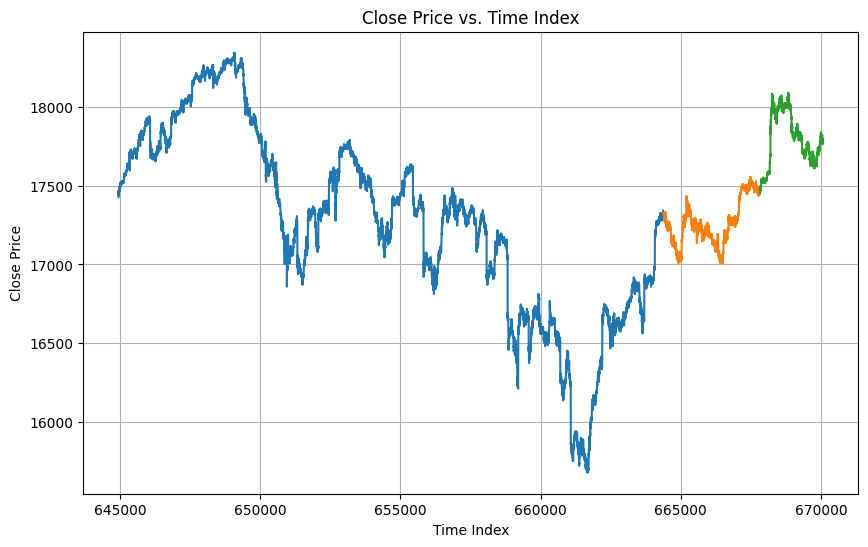

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_df['time_idx'], train_df['close'])
plt.plot(val_df['time_idx'], val_df['close'])
plt.plot(test_df['time_idx'], test_df['close'])
plt.xlabel('Time Index')
plt.ylabel('Close Price')
plt.title('Close Price vs. Time Index')
plt.grid(True)
plt.show()

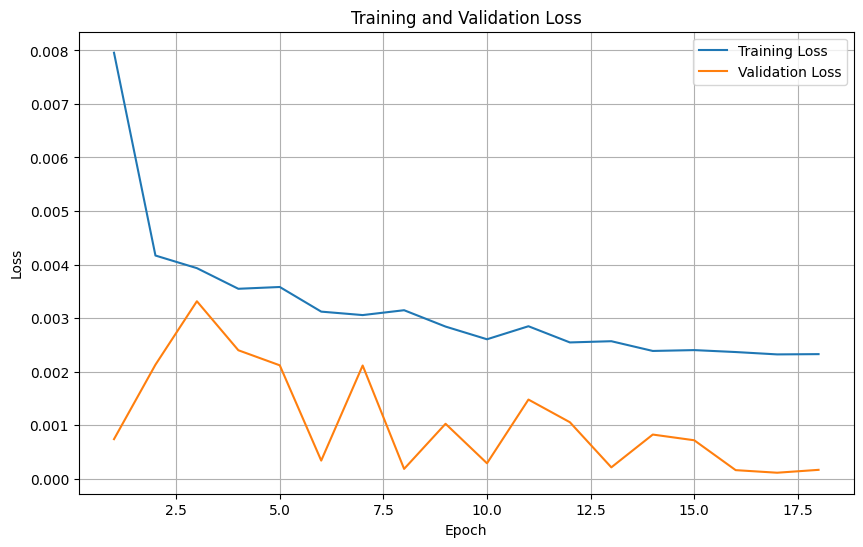

In [ ]:
train_losses = new_tft_lightning_module.train_losses_per_epoch
val_losses = new_tft_lightning_module.validation_losses_per_epoch

# Create epoch array
epochs = range(1, len(train_losses) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_df.shape

(19441, 23)

In [ ]:
val_df.shape

(3431, 23)

In [ ]:
test_df.shape

(2250, 23)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


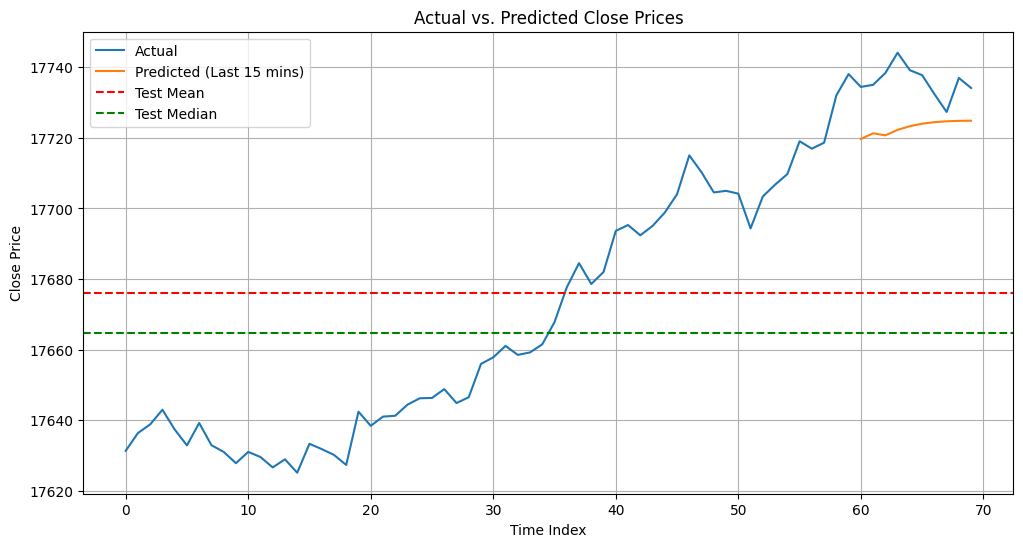

In [ ]:
start = 2000
input_context = 60
test_df1 = test_df[start:start+max_prediction_length+input_context]  # Select data from index 10001 to 10030 (30 minutes)

test_data = TimeSeriesDataSet.from_dataset(
    training_data,
    test_df1,
    predict=True,
    stop_randomization=True,
    # min_encoder_length=24,
    # max_encoder_length=24,
    # min_prediction_length=6,
    # max_prediction_length=6
)

test_dataloader = test_data.to_dataloader(batch_size=1, num_workers=0, train=False)

# Get predictions
predictions = new_tft.predict(test_dataloader)
# raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

predicted_close = predictions  # Example: Assuming a single output

# Determine the indices for the last 15 minutes of predictions
prediction_indices = range(input_context, len(test_df1))
actual_indices = range(0, len(test_df1))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_indices, test_df1['close'], label='Actual')
plt.plot(list(prediction_indices), predicted_close.tolist()[0], label='Predicted (Last 15 mins)')
# add horizontal line
plt.axhline(y=test_df1['close'].mean(), color='r', linestyle='--', label='Test Mean')
plt.axhline(y=test_df1['close'].median(), color='g', linestyle='--', label='Test Median')
# plt.axhline(y=train_df['close'].mean(), linestyle=':', label='Train Mean')
# plt.axhline(y=train_df['close'].median(), linestyle='-.', label='Train Median')
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.title("Actual vs. Predicted Close Prices")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
predictions

tensor([[17732.4492, 17732.7949, 17733.0469, 17733.4121, 17733.5840, 17733.7285,
         17733.9590, 17734.3105, 17734.7871, 17735.3730]], device='cuda:0')

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


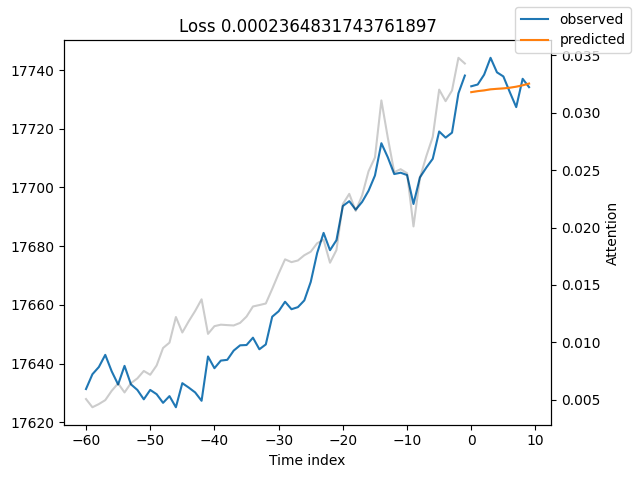

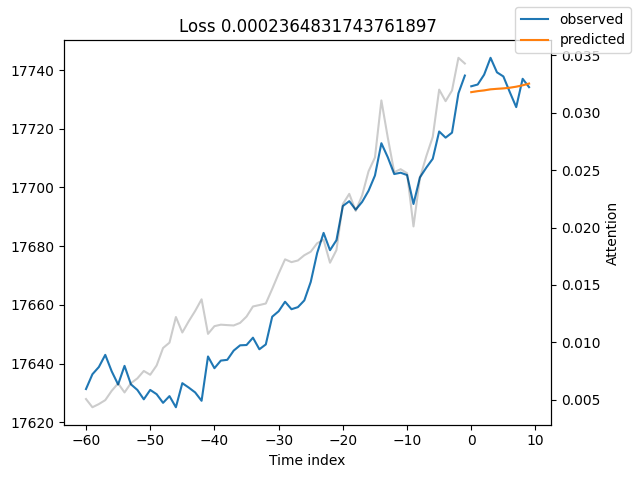

In [ ]:
# raw predictions
raw_preds = new_tft.predict(test_dataloader, mode="raw", return_x=True)

# plot raw predictions
new_tft.plot_prediction(x=raw_preds.x, out=raw_preds.output, idx=0, add_loss_to_title=True)

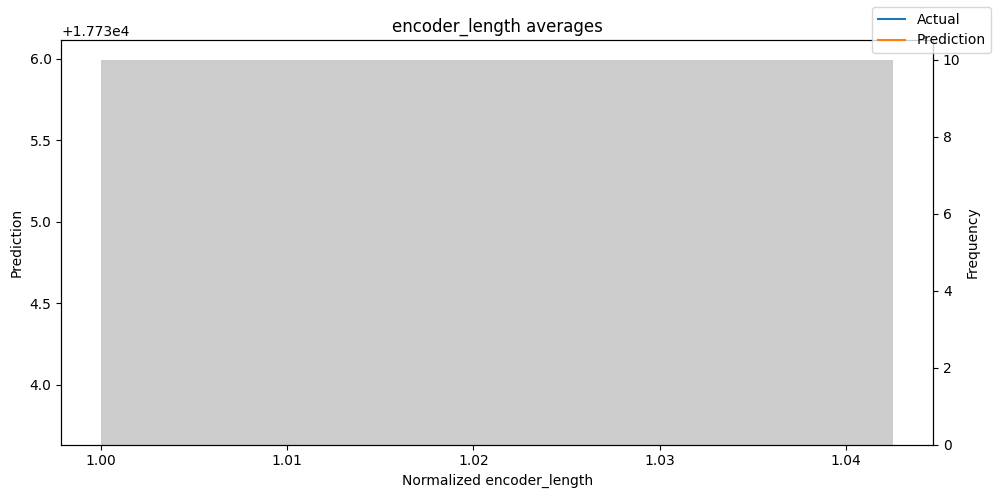

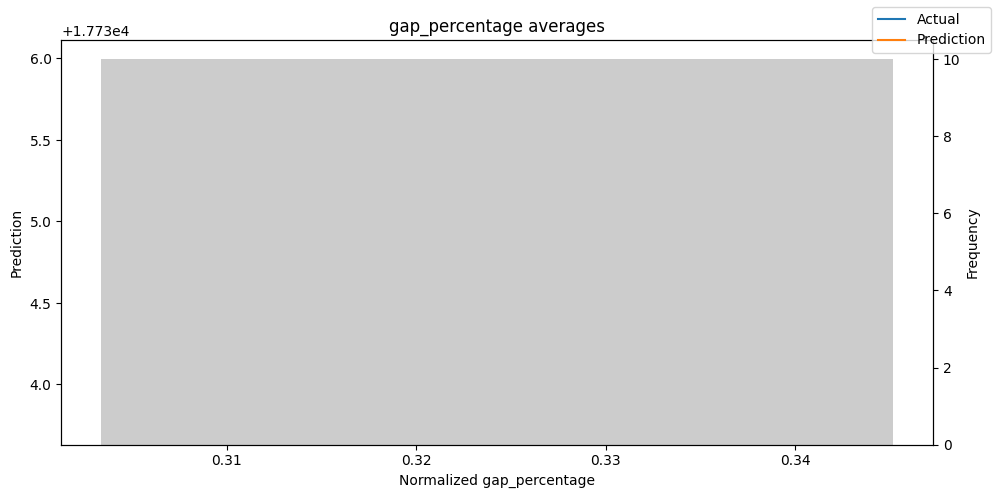

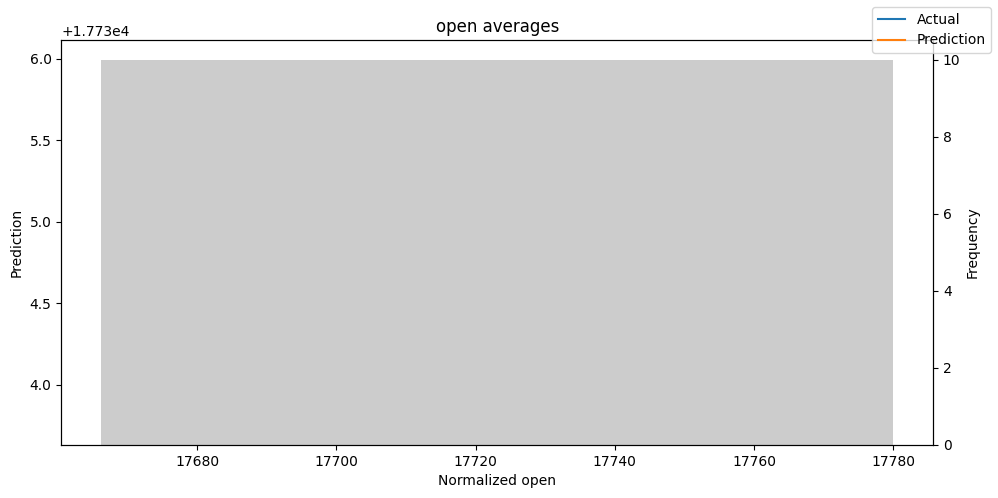

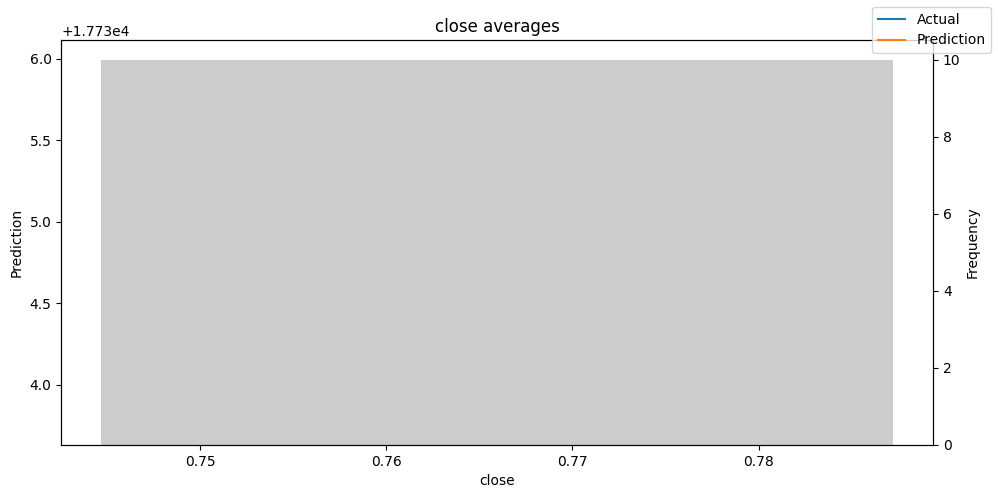

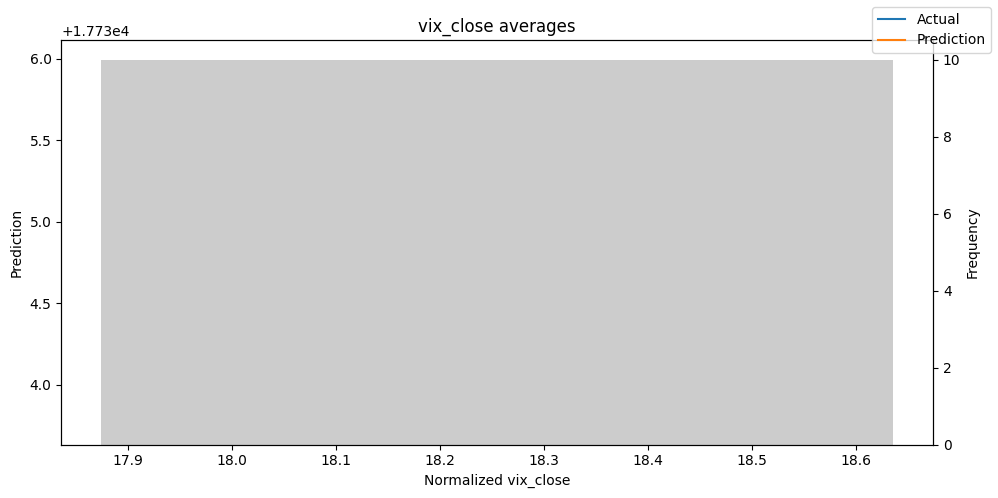

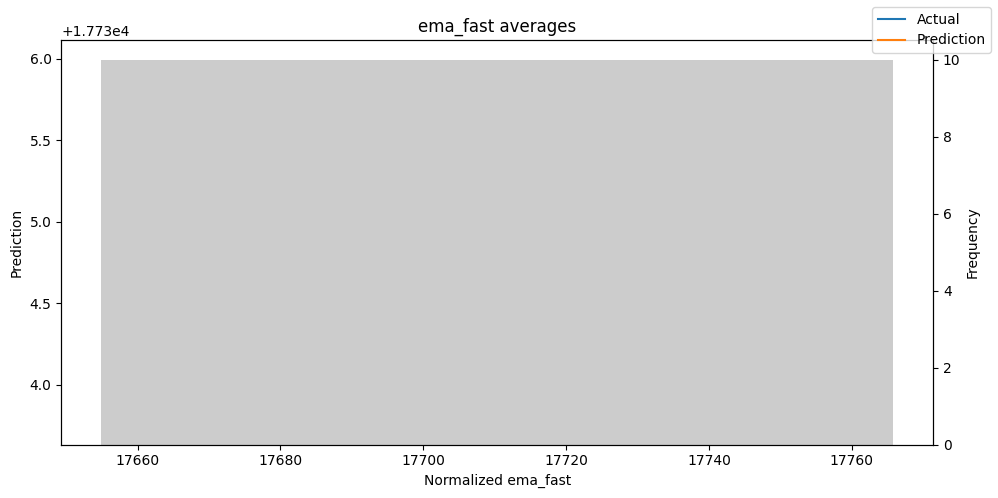

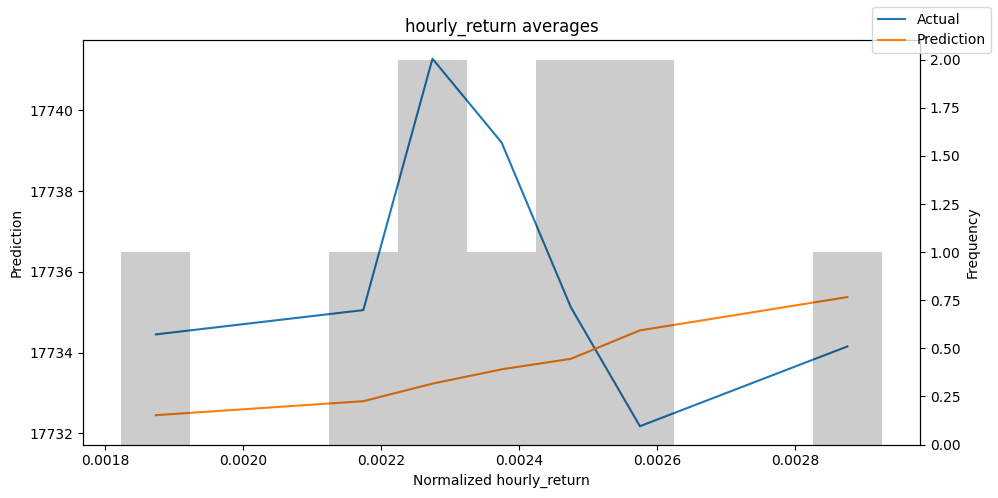

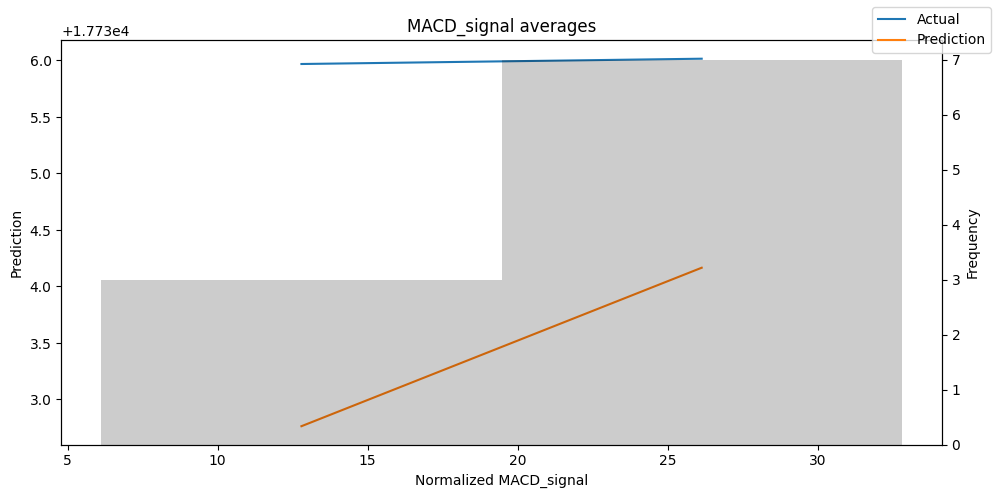

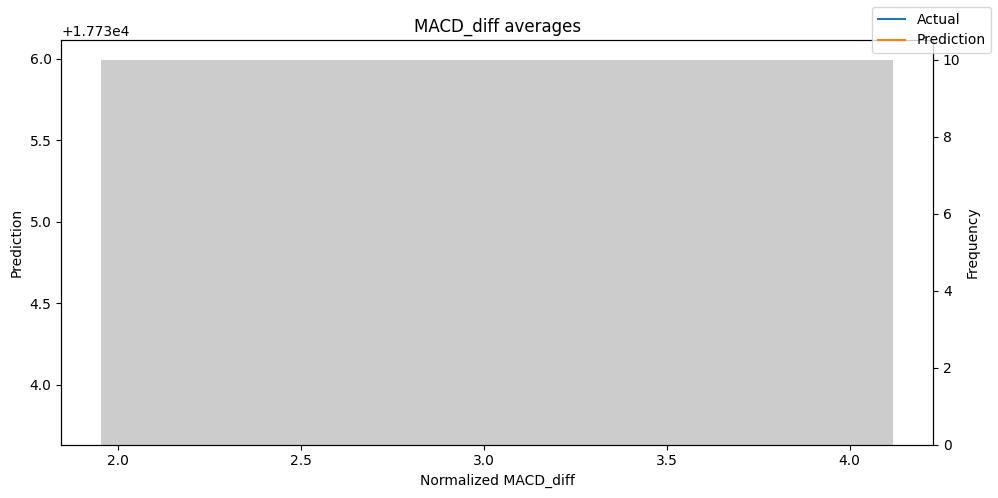

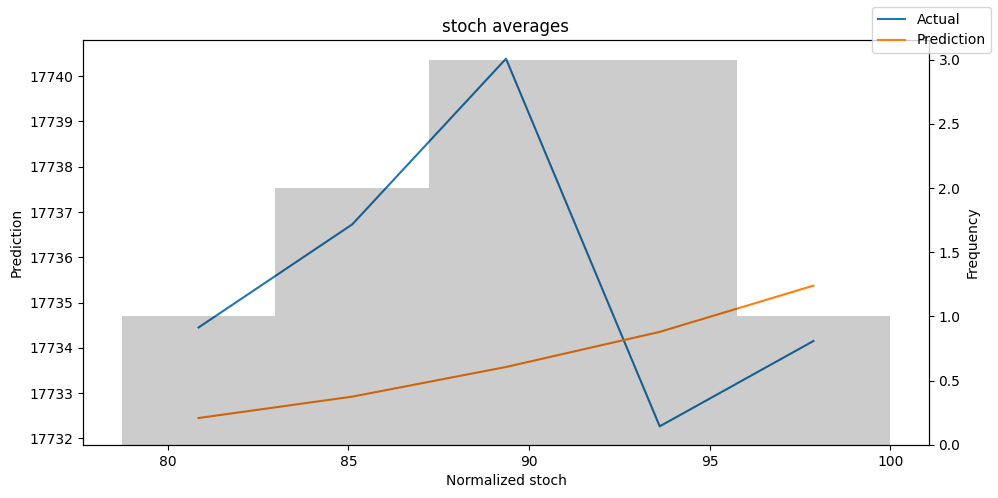

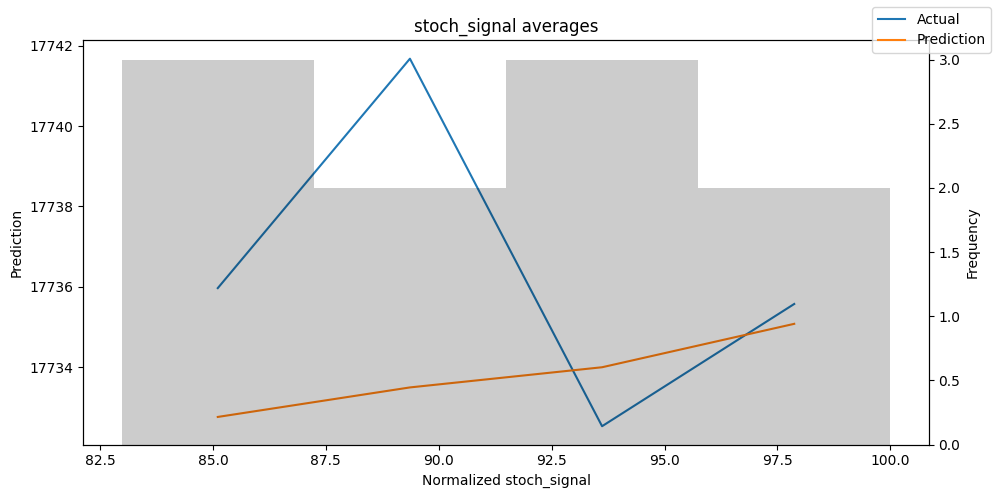

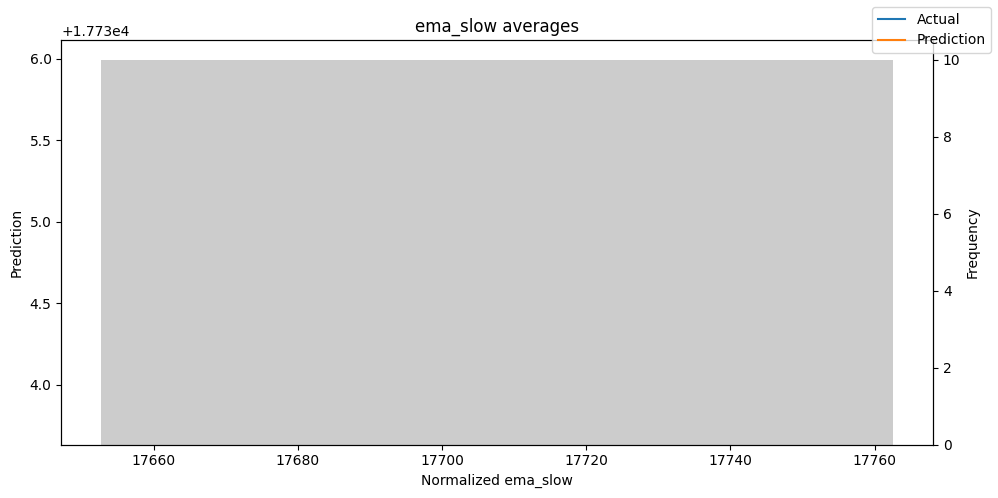

In [ ]:
predictions_vs_actuals = new_tft.calculate_prediction_actual_by_variable(
    raw_preds.x, raw_preds.output["prediction"]
)

plts = new_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
plts.keys()

dict_keys(['encoder_length', 'gap_percentage', 'open', 'close', 'vix_close', 'ema_fast', 'hourly_return', 'MACD_signal', 'MACD_diff', 'stoch', 'stoch_signal', 'ema_slow'])

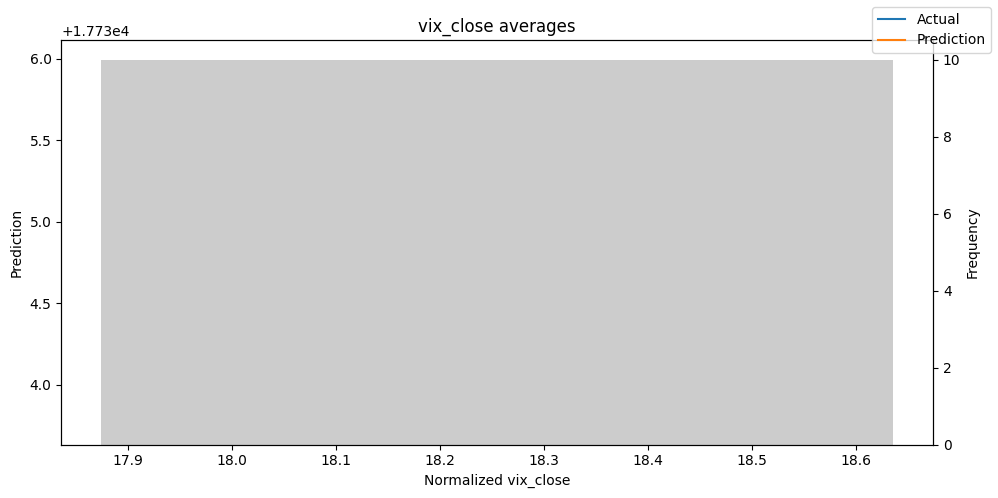

In [ ]:
plts['vix_close']

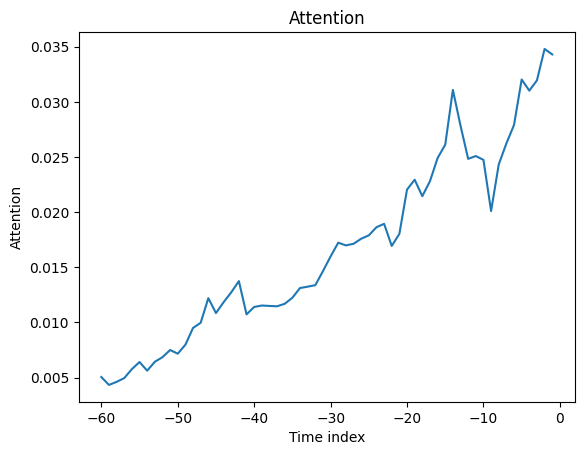

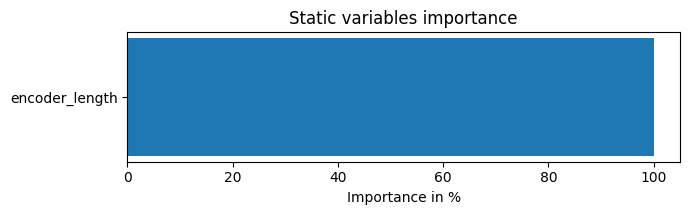

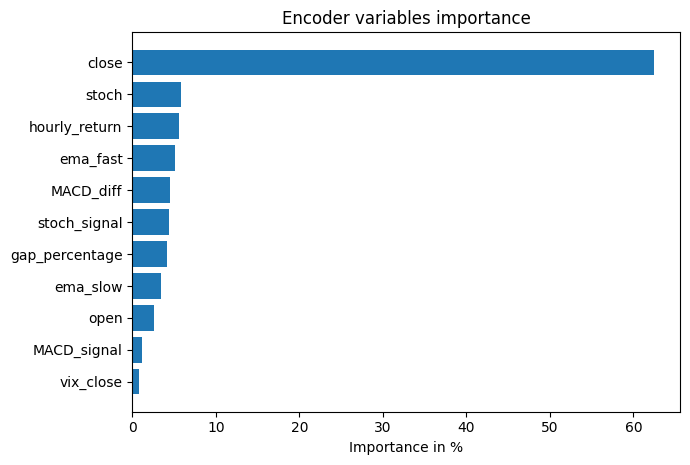

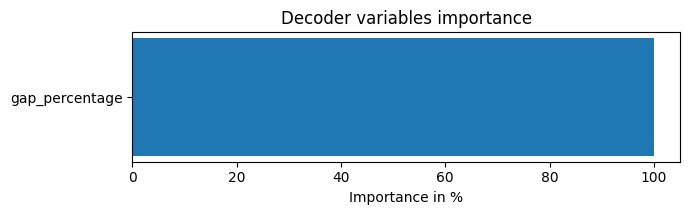

In [ ]:
interpretation = new_tft.interpret_output(raw_preds.output, reduction="sum")
int_plts = new_tft.plot_interpretation(interpretation)

In [ ]:
int_plts.keys()

dict_keys(['attention', 'static_variables', 'encoder_variables', 'decoder_variables'])